# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

import torch 
from torch import nn
from torch import optim
from torchvision import models, transforms, datasets

from collections import OrderedDict #for defining my classifier as an orderedDict

from workspace_utils import active_session #for keeping the session active 

import numpy as np

import matplotlib.pyplot as plt


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(), transforms.RandomRotation(30), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),
                  'testval': transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])}

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['testval'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['testval'])

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader= torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [4]:
for i in range(1):
    image = next(iter(train_loader))
    
    print(image)

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
# TODO: Build and train your network

I would be using the VGG19 as the pretrained network. 

In [5]:
#load in the VVG19 pretrained model

vggmodel= models.vgg19(pretrained = True)
vggmodel

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:13<00:00, 42041223.72it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Since the vgg19 classifier has an output of 1000, we would need to redefine the classifier to accomodate our output categories of 102

In [7]:
#freeze the model's classifier and define your own 

for param in vggmodel.parameters():
    param.requires_grad = False 
    
#now we can define our classifier with relu activation and dropout 


myclassifier = nn.Sequential(OrderedDict([('fc1',nn.Linear(25088, 2000)),
                                          ('relu', nn.ReLU()),
                                          ('Drop1', nn.Dropout(p= 0.2)),
                                          ('fc2',nn.Linear(2000, 500)),
                                          ('Drop2', nn.Dropout(p= 0.1)),
                                         ('relu', nn.ReLU()),
                                          ('fc3',nn.Linear(500, 102)),
                                         ('output', nn.LogSoftmax(dim= 1)) 
                                         ]))

vggmodel.classifier = myclassifier

In [9]:
#look at the model to see if the change has been effected
vggmodel 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Now we can go ahead to define our criterion and optimization and then train the model. 

In [8]:
#define criterion 
criterion = nn.NLLLoss()

#define optimization with the SGD optimization

optimizer = optim.Adam(vggmodel.classifier.parameters(), lr = 0.001)


In [9]:
#define a variable to check if the GPU is available

interface = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Now to training the model. 

In [12]:
with active_session(): #keep the session active 
    
    epochs = 13
    vggmodel.cuda() #move the model to the GPU if GPU is available
    
    for e in range(epochs):
        running_loss = 0 #track the running loss of the training
        
        
        for images, labels in train_loader:
            
            images = images.cuda() 
            labels = labels.cuda() # move the images and labels to the GPU too
            
            #zero the gradients first 
            optimizer.zero_grad()
            
            output = vggmodel.forward(images)
            loss = criterion(output, labels)
            
            #perform backward pass and optimize
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            
        #now for the validation 
        
        else:
            test_loss = 0  #define test loss variable to store the loss at each epoch during validation
            accuracy = 0
            
            with torch.no_grad(): #turn of the gradients, this is not training 
                vggmodel.eval() #put the model in evaluation mode
                
                for images, labels in valid_loader:
                    #send the validation data to the GPU too... the model is already on the GPU
                    
                    images, labels = images.to(interface), labels.to(interface)
                    
                    #do the forward pass.. since the model is in evaluation mode, the gradients are already off
                    logps = vggmodel.forward(images)
                    
                    #calculate the loss for the batch
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    #calculate the accuracy 
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim= 1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                #print the train loss, validation loss and accuracy for each epoch
                
                print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/len(train_loader):.3f}.. "
                  f"Validation loss: {test_loss/len(test_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(test_loader):.3f}")
                
                vggmodel.train() #put the model back in training mode for the next epoch

            
        
        

Epoch 1/13.. Train loss: 2.849.. Validation loss: 1.796.. Validation accuracy: 0.515
Epoch 2/13.. Train loss: 1.776.. Validation loss: 1.341.. Validation accuracy: 0.616
Epoch 3/13.. Train loss: 1.598.. Validation loss: 1.272.. Validation accuracy: 0.677
Epoch 4/13.. Train loss: 1.449.. Validation loss: 1.339.. Validation accuracy: 0.662
Epoch 5/13.. Train loss: 1.421.. Validation loss: 1.281.. Validation accuracy: 0.668
Epoch 6/13.. Train loss: 1.420.. Validation loss: 1.185.. Validation accuracy: 0.694
Epoch 7/13.. Train loss: 1.343.. Validation loss: 1.108.. Validation accuracy: 0.718
Epoch 8/13.. Train loss: 1.346.. Validation loss: 1.107.. Validation accuracy: 0.712
Epoch 9/13.. Train loss: 1.279.. Validation loss: 1.095.. Validation accuracy: 0.706
Epoch 10/13.. Train loss: 1.293.. Validation loss: 1.150.. Validation accuracy: 0.708
Epoch 11/13.. Train loss: 1.220.. Validation loss: 1.124.. Validation accuracy: 0.705
Epoch 12/13.. Train loss: 1.223.. Validation loss: 1.181.. Vali

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set

In [13]:
with active_session():
    
    test_loss = 0  #define test loss variable to store the loss at each epoch during validation
    accuracy = 0
            
    with torch.no_grad(): #turn of the gradients, this is not training 
        vggmodel.eval() #put the model in evaluation mode
                
        for images, labels in test_loader:
            #send the test data to the GPU too... the model is already on the GPU
                    
            images, labels = images.to(interface), labels.to(interface)
                    
            #do the forward pass.. since the model is in evaluation mode, the gradients are already off
            logps = vggmodel.forward(images)
                    
            #calculate the loss for the batch
            batch_loss = criterion(logps, labels)
                    
            test_loss += batch_loss.item()
                    
            #calculate the accuracy 
                    
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim= 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
        #print the train loss, validation loss and accuracy for each epoch
                
        print(f"Test loss: {test_loss/len(test_loader):.3f}.. "
            f"Test accuracy: {accuracy/len(test_loader):.3f}")


Test loss: 1.039.. Test accuracy: 0.732


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
# # TODO: Save the checkpoint 

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'hidden_layers': [each.out_features for each in [vggmodel.classifier.fc1, vggmodel.classifier.fc2, vggmodel.classifier.fc3]],
              'state_dict': vggmodel.state_dict(),
             'epochs':16, 
             'optimizer':optimizer.state_dict(),
              'cat_to_name_mapping': train_data.class_to_idx
             }

torch.save(checkpoint, 'checkpoint.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
chekLoad = torch.load('checkpoint.pth', map_location='cpu')

In [6]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    #interface = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    checkpoint = torch.load(filepath, map_location='cpu')
    
    vggmodel = models.vgg19(pretrained=True)
    
    myclassifier = nn.Sequential(OrderedDict([('fc1',nn.Linear(25088, 2000)),
                                          ('relu', nn.ReLU()),
                                          ('Drop1', nn.Dropout(p= 0.2)),
                                          ('fc2',nn.Linear(2000, 500)),
                                          ('Drop2', nn.Dropout(p= 0.1)),
                                         ('relu', nn.ReLU()),
                                          ('fc3',nn.Linear(500, 102)),
                                         ('output', nn.LogSoftmax(dim= 1)) 
                                         ]))
    vggmodel.classifier = myclassifier
    
    vggmodel.load_state_dict(checkpoint['state_dict'])
    
    vggmodel.class_to_idx = checkpoint['cat_to_name_mapping']
    
    return vggmodel

    
    
    


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [7]:
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    means = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    
    
    # open the image using PIL
    im = Image.open(image)
    
    
    
    #view the original image 
    #fig, ax = plt.subplots(1,2)
    #ax[0].imshow(im)
    
    
    
    im.thumbnail((256, 256))
        
    #crop the image with crop method 
    width, height = im.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
        
    im = im.crop((left, top, right, bottom))
    
    #view 
    #ax[1].imshow(im)

    #change the image to a numpy array    
    im = np.array(im)/255   
    
    #Normalize with the means and standard deviation 
    
    im = (im - means) / std


    #view 
    #ax[2].imshow(im)
    
    
    im = im.transpose()
    
    
    #view
    #ax.imshow(im)
        
    return im
        
    
    # TODO: Process a PIL image for use in a PyTorch model

In [54]:
image_path = 'flowers/valid/100/image_07895.jpg'

In [55]:
proc_image = process_image(image_path)

In [56]:
#get the name of the flower using its class label that can be found in the path 

label =image_path.split('/')[2]
name = cat_to_name[label] # index that mapping from category to name using the label 
name

'blanket flower'

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [57]:
def imshow(image, ax=None, title=None, name= None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
   
    
    ax.imshow(image)
    ax.set_title(name)
    
    return ax

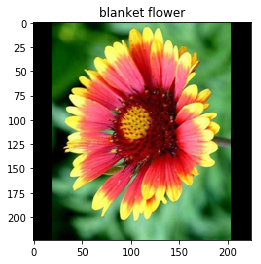

In [58]:
imshow(proc_image, name= name );

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [59]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    Arguments:
    image_path: path to the image 
    model: model's checkpoint that would be loaded using the load_checkpoint function
    
    '''
    model = load_checkpoint(model)
    interface = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(interface)
    model.eval()
    
    image = process_image(image_path)
    image = torch.from_numpy(image)
    
    """unsqueeze adds the batch size to the size of the image, the model expects the size to have four dimensions 

    """    
    image = image.unsqueeze_(0)
    
    ''' image.float() below 
    converts the input to a FloatTensor instead of a DoubleTensor 
    to match the model because the weights and biases of the model are 
    by default FloatTensors

    '''
    image = image.float()    
    
    #print(image.shape)
    

    image = image.to(interface)  
    
    with torch.no_grad():

        top_probs, top_classes = [],[]
        output_logps = model.forward(image)
        
        ps = torch.exp(output_logps)
        
        top_p, top_index = ps.topk(topk, dim = 1)
        #print(top_p)
        #print(top_class)
        
        #make a mapping from the output index to the classes 
        idx_to_class = {indx: class_ for class_,indx in model.class_to_idx.items()}
        
        #make a list out of the tensor for the top_p probabilities 
        for i in range(topk):
            top_probs.append(top_p[0][i].item())
        
        #map from index to class
        for i in range(topk):
            idx = top_index[0][i].item()
            clas = idx_to_class[idx]
            top_classes.append(clas)
            
           
        
        
    return top_probs, top_classes
    
    # TODO: Implement the code to predict the class from an image file

In [60]:
predict(image_path, 'checkpoint.pth')

([0.9986809492111206,
  0.0013077137991786003,
  8.498191164107993e-06,
  1.1802187600551406e-06,
  1.0704078476919676e-06],
 ['100', '5', '54', '41', '71'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [61]:
#get the flower names using the classes obtained after retrieving the topk probabilities 
top_p, top_classes = predict(image_path,'checkpoint.pth')


In [62]:
top_classes

['100', '5', '54', '41', '71']

In [65]:
top_p

[0.9986809492111206,
 0.0013077137991786003,
 8.498191164107993e-06,
 1.1802187600551406e-06,
 1.0704078476919676e-06]

In [63]:
#create a list of the class names from the indices and classes 
class_names = []
for indx in top_classes:
    class_names.append(cat_to_name[indx])

In [66]:
class_names

['blanket flower',
 'english marigold',
 'sunflower',
 'barbeton daisy',
 'gazania']

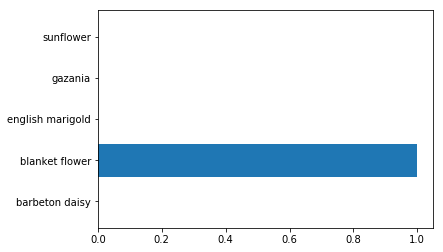

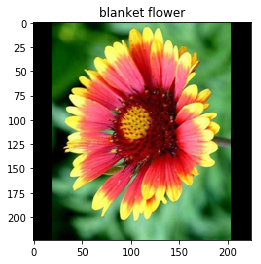

In [67]:
#show the image and plot the probabilities

image = process_image(image_path)



plt.barh(class_names, top_p);

imshow(image, name= name);



# Alternatives 

### Defining the network architecture as a class instead of using the Sequencial function:

In [ ]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = nn.Dropout(x, p = 0.4)
        x = self.activation(self.fc2(x))
        x = nn.Dropout(x, p = 0.4)
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

### Training and testing without the Udacity custom active session function to keep the environment alive

In [ ]:


epochs = 13
net.cuda() #move the model to the GPU if GPU is available

for e in range(epochs):
    running_loss = 0 #track the running loss of the training


    for images, labels in trainloader:

        images = images.cuda() 
        labels = labels.cuda() # move the images and labels to the GPU too

        #zero the gradients first 
        optimizer.zero_grad()

        output = net.forward(images)
        loss = criterion(output, labels)

        #perform backward pass and optimize

        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    #now for the validation 

    else:
        test_loss = 0  #define test loss variable to store the loss at each epoch during validation
        accuracy = 0

        with torch.no_grad(): #turn of the gradients, this is not training 
            net.eval() #put the model in evaluation mode

            for images, labels in testloader:
                #send the validation data to the GPU too... the model is already on the GPU

                images, labels = images.to(interface), labels.to(interface)

                #do the forward pass.. since the model is in evaluation mode, the gradients are already off
                logps = net.forward(images)

                #calculate the loss for the batch
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                #calculate the accuracy 

                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim= 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            #print the train loss, validation loss and accuracy for each epoch

            print(f"Epoch {e+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Validation loss: {test_loss/len(testloader):.3f}.. "
              f"Validation accuracy: {accuracy/len(testloader):.3f}")

            vggmodel.train() #put the model back in training mode for the next epoch





In [ ]:
#testing 
accuracy = 0

with torch.no_grad(): #turn off gradients to stop keeping track of gradients 
    net.eval() #put the model in evaluation mode

    for i, data in enumerate(testloader):
        #send the test data to the GPU

        images, labels = data

        images, labels = images.to(device), labels.to(device)

        #proceed with the forward pass 
        outputs = net.forward(images)
        
        #accuracy calculation 
        _, predictions = torch.max(outputs.data, 1)
        correct_preds = (preds == labels).sum().item
        accuracy = correct_preds/len(testloader)

        #calculate the loss for the batch
        #batch_loss = criterion(logps, labels)

        #calculate the accuracy 

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim= 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    #print the train loss, validation loss and accuracy for each epoch

    print(f"Test accuracy: {accuracy/len(testloader):.3f}")
